In [1]:
%load_ext autoreload

In [2]:
%autoreload

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns
import torch
from tqdm.notebook import tqdm
from utils import latexify

torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
latexify(6, 4)

In [4]:
ETFS = ['AGG', 'VTI', 'VNQ', 'XLF', 'XLV', 'XLY', 'XLP', 'XLU', 'XLI', 'XLE', 'IBB', 'ITA']

In [5]:
N_ASSETS = len(ETFS)
HZN = 24
VAL = 2443
TEST = VAL * 3
KAPPA = np.full(N_ASSETS, 0.001)
SHORT = np.full(N_ASSETS, 0.001)
GAMMA = 15.0

M1 = torch.tensor(2.0)
M2 = torch.tensor(1.00)
len(ETFS)

12

In [6]:
MU = np.load('data/markowitz_mu.npy')
COV = np.load('data/markowitz_sigma.npy')
COV_SQRT = scipy.linalg.sqrtm(COV)

mulog = torch.tensor(np.load('data/markowitz_mu_log.npy'))
covlog = torch.tensor(np.load('data/markowitz_cov_log.npy'))

In [7]:
def init_holdings(cov_sqrt, mu, gamma):
    N = N_ASSETS
    ht = cp.Variable(N)   
    
                                                                                                                                                        
    risk = gamma * cp.sum_squares(cov_sqrt @ ht)
    returns = mu.T @ ht
    objective = returns - risk - SHORT.T @ cp.neg(ht)
                                                                                
    constraints = [                                                             
        cp.sum(ht) == 1,
    ]                                                                            
    problem = cp.Problem(cp.Maximize(objective), constraints)
    problem.solve()
    return ht.value

H0 = torch.tensor(init_holdings(COV_SQRT, MU, GAMMA))

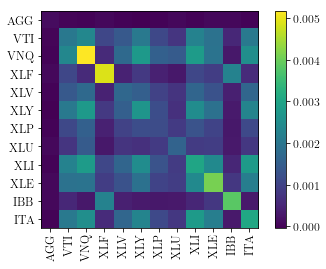

In [8]:
plt.imshow(COV)
plt.colorbar()
plt.xticks(np.arange(N_ASSETS), ETFS, rotation=90)
plt.yticks(np.arange(N_ASSETS), ETFS)
plt.show()

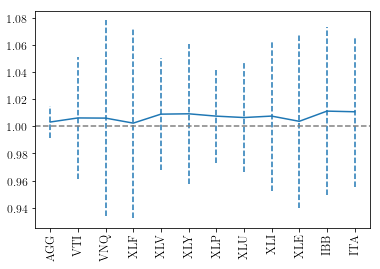

In [9]:
def plot_mean_std(mu, cov):
    ax = plt.gca()
    eb = plt.errorbar(np.arange(N_ASSETS), mu, yerr=np.sqrt(np.diag(cov)))
    eb[-1][0].set_linestyle('--')
    ax.axhline(1.0, linestyle='--', color='gray')
    plt.xticks(np.arange(N_ASSETS), ETFS, rotation=90)
    
plot_mean_std(MU, COV)
plt.show()

In [10]:
kappa_tch = torch.from_numpy(KAPPA)
logreturn1p_dist = torch.distributions.MultivariateNormal(
    mulog, covlog)


def utility_fn(x, m1=M1, m2=M2):
    return torch.min(m1*(x - 1), m2*(x - 1))                                                  


def stage_cost(r):                                                       
    return -utility_fn(r)


def simulate(ht, ut):
    ret = torch.exp(logreturn1p_dist.sample())
    ht = ret * (ht + ut)
    return ht, ret


def rollout(policy, h0=H0, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    ht = h0                                                                    
    h_seq = [ht]                                                               
    u_seq = []    
    rets = []
    cost = 0.0
    for t in range(HZN):                                                    
        ut = policy(ht)
        htp1, _ = simulate(ht, ut)
        ret = htp1.sum() / ht.sum()
        cost += stage_cost(ret).mean()
        ht = htp1
        h_seq.append(ht)                                                        
        u_seq.append(ut)
        rets.append(ret)
    cost = cost / HZN
    return cost, h_seq, u_seq, rets


def monte_carlo(policy, h0=H0, trials=10, seed=None, verbose=True):
    if seed is not None:
        torch.manual_seed(seed)
    results = []
    hN = []
    
    if verbose:
        wrapper = lambda x: tqdm(x)
    else:
        wrapper = lambda x: x
    
    for i in wrapper(range(trials)):
        cost, h_seq, _, rets = rollout(policy, h0)
        results.append(cost)
        hN.append(h_seq[-1])
    return torch.stack(results), hN, rets

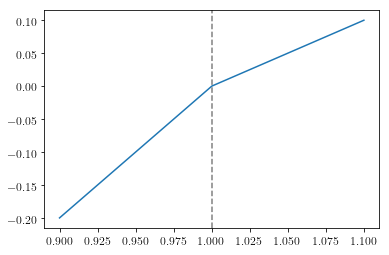

In [11]:
ax = plt.gca()
plt.plot(np.linspace(0.9, 1.1, 1000), [utility_fn(x) for x in np.linspace(.9, 1.1, 1000)])
ax.axvline(1, color='gray', linestyle='--')
plt.show()

In [12]:
def plot_states(policy, ax=None, h0=H0, seed=TEST, style={},
                legend=False, ylabel=True, xlabel=True):
    if ax is None:
        ax = plt.gca()
    colors = sns.color_palette("hls", N_ASSETS)
    _, states, _, _ = rollout(policy, h0=h0, seed=seed)
    normalized = [s / s.sum() for s in states]
    states_stacked = torch.stack(normalized)
    states_np = states_stacked.detach().numpy()
    for i, etf in enumerate(ETFS):
        holdings = states_np[:, i]
        if etf in style:
            ax.plot(holdings, label=etf, linestyle=style[etf], color=colors[i])
        else:
            ax.plot(holdings, label=etf, color=colors[i])
    if xlabel:
        ax.set_xlabel("month")
    if ylabel:
        ax.set_ylabel("holdings")
    ax.set_xticks(np.arange(HZN, step=4))
    ax.set_xlim((0, HZN))
    ax.set_ylim((-.75, .95))
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
    plt.tight_layout()
    
    
def plot_controls(policy, ax=None, h0=H0, seed=TEST, style={},
                  legend=False, ylabel=True, xlabel=True):
    if ax is None:
        ax = plt.gca()
    _, states, controls, _ = rollout(policy, h0=h0, seed=seed)
    colors = sns.color_palette("hls", N_ASSETS)
    normalized = [c / s.sum() for s, c in zip(states, controls)]
    stacked = torch.stack(normalized)
    controls_np = stacked.detach().numpy()
    for i, etf in enumerate(ETFS):
        ctrl = controls_np[:, i]
        if etf in style:
            ax.plot(ctrl, label=etf, linestyle=style[etf], color=colors[i])
        else:
            ax.plot(ctrl, label=etf, color=colors[i])
    ax.set_xticks(np.arange(HZN, step=4))
    ax.set_xlim((0, HZN))
    if xlabel:
        ax.set_xlabel('month')
    if ylabel:
        ax.set_ylabel('trades')
    if legend:
        ax.legend()
    plt.tight_layout()

In [13]:
def construct_layer():
    N = N_ASSETS
    ht = cp.Parameter(N)   
    cov_sqrt = cp.Parameter((N, N))
    mu = cp.Parameter(N)
    parameters = [ht, cov_sqrt, mu]                     
                                                                                
    ut = cp.Variable(N)                                                         
    htp = cp.Variable(N)             
                                                                                
    risk = cp.sum_squares(cov_sqrt @ htp)
    returns = mu.T @ htp
    objective = returns - risk
                                                                                
    transaction_cost = KAPPA.T @ cp.abs(ut)
    shorting_cost = SHORT.T @ cp.neg(htp)
    constraints = [                                                             
        cp.sum(ut) + transaction_cost + shorting_cost <= 0,                                   
        htp == ht + ut,
    ]                                                                            
    problem = cp.Problem(cp.Maximize(objective), constraints)
    return CvxpyLayer(problem, parameters, [ut])   

In [14]:
class Tuner(object):                                                       
    def __init__(self, mu=MU, gamma=GAMMA, cov_sqrt=COV_SQRT):            
        self.layer = construct_layer()  
        
        self.gamma_sqrt = torch.tensor(np.sqrt(gamma), requires_grad=True)
        self.cov_sqrt = torch.tensor(cov_sqrt, requires_grad=True)
        self.mu = torch.tensor(mu, requires_grad=True)
        self.variables = [self.gamma_sqrt, self.cov_sqrt, self.mu]
        self.solver_args= {'acceleration_lookback': 0, 'max_iters': 10000}      

    def __call__(self, ht):
        norm_ht = ht / ht.sum()
        norm_ut = self.layer(
            norm_ht, self.gamma_sqrt * self.cov_sqrt, self.mu,
            solver_args=self.solver_args)[0]
        return norm_ut * ht.sum()

    def project(self):
        self.gamma_sqrt.data = torch.max(self.gamma_sqrt, torch.tensor(0.0))
        
        
untuned = Tuner(gamma=GAMMA, cov_sqrt=COV_SQRT)

In [15]:
STYLE = {
    'AGG': '--',
    'ITA': ':'
}

In [16]:
def train(policy, epochs, batch_size=10, lr=1e-2, print_every=50):    
    opt = torch.optim.SGD(policy.variables, lr=lr)                             
    print("Training for {} epochs (batch size={}, lr={})".format(epochs, batch_size, lr))
    test_utils = []
    
    with torch.no_grad():
        test_costs, _, _ = monte_carlo(policy, trials=batch_size, seed=TEST, verbose=False)
        test_utils.append(-test_costs.mean())
        print('start: test utility ({})'.format(test_utils[-1]))
        
    for epoch in tqdm(range(epochs)):  
        
        if (epoch + 1) % 100 == 0:
            lr = lr / 2
            opt = torch.optim.SGD(policy.variables, lr=lr)
            
        with torch.no_grad():
            h0 = init_holdings(policy.cov_sqrt.detach().numpy(), policy.mu.detach().numpy(),
                               policy.gamma_sqrt.detach().item()**2)
            h0 = torch.tensor(h0)
            
        opt.zero_grad()
        costs, _, _ = monte_carlo(policy, h0=h0, trials=batch_size, seed=epoch, verbose=False)
        costs.mean().backward()
        
        with torch.no_grad():
            test_costs, _, _ = monte_carlo(policy, h0=h0, trials=batch_size, seed=TEST, verbose=False)
            test_utils.append(-test_costs.mean())
            print('epoch {}: train utility ({}) test utility ({})'.format(
                epoch, -costs.mean(), test_utils[-1]))
            if epoch % print_every == 0:
                print('\tmu.grad.norm ', policy.mu.grad.norm().item())
                print('\tgamma.grad.norm ', policy.gamma_sqrt.grad.norm().item())
                print('\tcov_sqrt.grad.norm ', policy.cov_sqrt.grad.norm().item())
                print('\tgamma ', policy.gamma_sqrt.detach().item()**2)
                plot_mean_std(policy.mu.detach().numpy(),
                             (policy.cov_sqrt.T @ policy.cov_sqrt).detach().numpy())
                plt.show()
                
                plot_states(policy, h0=h0, seed=TEST, style=STYLE, legend=True)
                plt.show()
                
                plot_controls(policy, h0=h0, seed=TEST, style=STYLE)
                plt.show()
                
        opt.step()
        with torch.no_grad():                                                   
            policy.project()                                                    
            
    return test_utils

Training for 400 epochs (batch size=10, lr=0.001)
start: test utility (0.00420475926125433)


epoch 0: train utility (0.002995137190558765) test utility (0.004204759261254224)
	mu.grad.norm  0.2743663782904225
	gamma.grad.norm  0.0002907444727503857
	cov_sqrt.grad.norm  0.225126868887498
	gamma  15.000000000000002


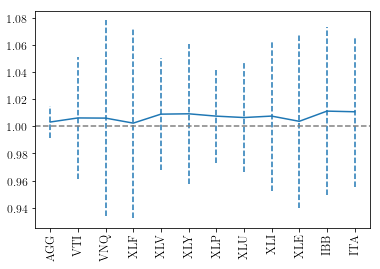

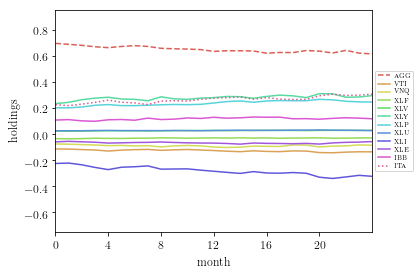

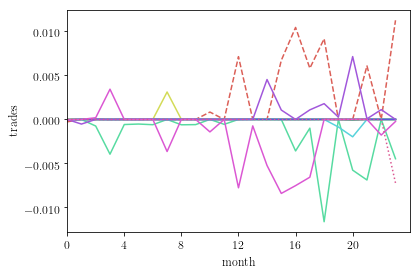

epoch 1: train utility (0.0035706827880657628) test utility (0.004170761808899146)
epoch 2: train utility (0.00620341954079587) test utility (0.004196166070047568)
epoch 3: train utility (0.0006756042183720741) test utility (0.0042347666497604824)
epoch 4: train utility (0.004051564900212402) test utility (0.004263197515989527)
epoch 5: train utility (0.0020147450599273145) test utility (0.004298573899369322)
epoch 6: train utility (0.0027742879918811547) test utility (0.004302329242517964)
epoch 7: train utility (0.004112582568560763) test utility (0.0043068898025133895)
epoch 8: train utility (0.0035672051073303472) test utility (0.004330946536917044)
epoch 9: train utility (1.6557361110976785e-05) test utility (0.004365846963970228)
epoch 10: train utility (0.006095436244030455) test utility (0.004354480453061983)
	mu.grad.norm  0.3321270469376509
	gamma.grad.norm  0.0011732822742775908
	cov_sqrt.grad.norm  0.2824495200402201
	gamma  14.999983530757618


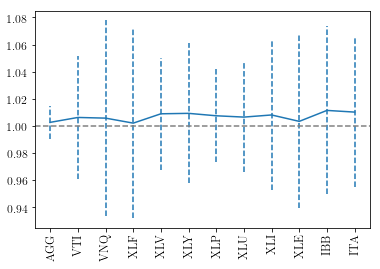

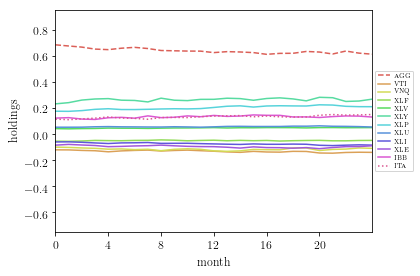

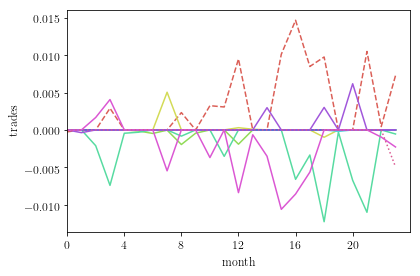

epoch 11: train utility (0.003351608017779866) test utility (0.0043773805851088105)
epoch 12: train utility (0.002246174407847016) test utility (0.0044048506383990715)
epoch 13: train utility (0.00636237789445587) test utility (0.004417413283820651)
epoch 14: train utility (0.0037398178349900544) test utility (0.004488185297818156)
epoch 15: train utility (0.002554415081024539) test utility (0.004499199289517502)
epoch 16: train utility (0.003365850866160091) test utility (0.0044953731360231055)
epoch 17: train utility (0.0028327691407042796) test utility (0.004490177978254153)
epoch 18: train utility (0.0029390063355521513) test utility (0.0045038960940547625)
epoch 19: train utility (0.002771865307784032) test utility (0.004475061643952347)
epoch 20: train utility (0.0031487387274912737) test utility (0.004512118363592634)
	mu.grad.norm  0.3514775895239826
	gamma.grad.norm  0.00015943734560618474
	cov_sqrt.grad.norm  0.30343621712194085
	gamma  14.999950222141475


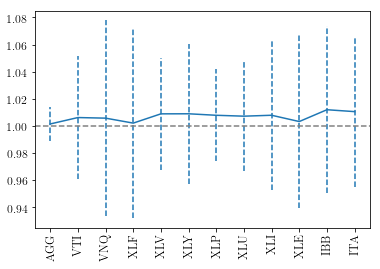

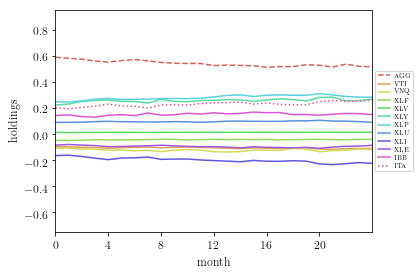

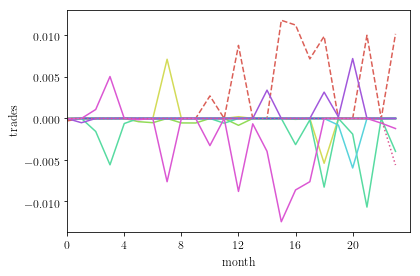

epoch 21: train utility (0.0011593976108239053) test utility (0.004516331758327091)
epoch 22: train utility (0.0016315077100103547) test utility (0.004518245498047615)
epoch 23: train utility (0.002112558276611709) test utility (0.004506874223446056)
epoch 24: train utility (0.0046738136569569695) test utility (0.004521583039217326)
epoch 25: train utility (0.0033719579414188865) test utility (0.004537573840878596)
epoch 26: train utility (0.005837362029103833) test utility (0.0046146834895106304)
epoch 27: train utility (0.005296516548951689) test utility (0.004631547444907054)
epoch 28: train utility (0.00482891154420456) test utility (0.004679042207813544)
epoch 29: train utility (0.003250006511788013) test utility (0.0046721801824617425)
epoch 30: train utility (0.003285485120462425) test utility (0.004697189548162347)
	mu.grad.norm  0.2980549395416987
	gamma.grad.norm  0.00015605282905000248
	cov_sqrt.grad.norm  0.22306781184446972
	gamma  14.999920126659937


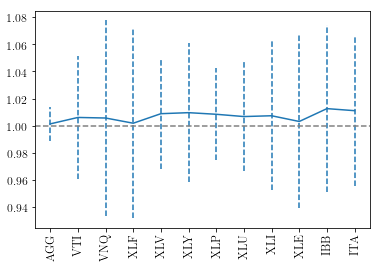

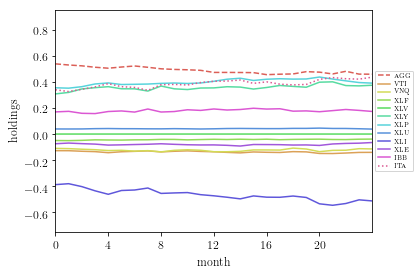

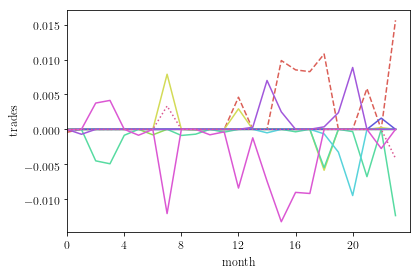

epoch 31: train utility (0.0011842282248606026) test utility (0.004684433007733311)
epoch 32: train utility (0.00174524211135692) test utility (0.004630307617302415)
epoch 33: train utility (0.005100475802207279) test utility (0.004627619569166405)
epoch 34: train utility (0.003304819499695163) test utility (0.004638404678127521)
epoch 35: train utility (0.002465247804381453) test utility (0.004616466029334261)
epoch 36: train utility (0.003813598148298723) test utility (0.004625825280815963)
epoch 37: train utility (0.003581453044123704) test utility (0.0046652284778333514)
epoch 38: train utility (0.00488307051867883) test utility (0.004733029379994728)
epoch 39: train utility (0.0030421090141295386) test utility (0.004744163492864674)
epoch 40: train utility (0.004157596405769598) test utility (0.00466354162282526)
	mu.grad.norm  0.476235113494531
	gamma.grad.norm  0.0001598620904097519
	cov_sqrt.grad.norm  0.3424474400265672
	gamma  14.99990793287591


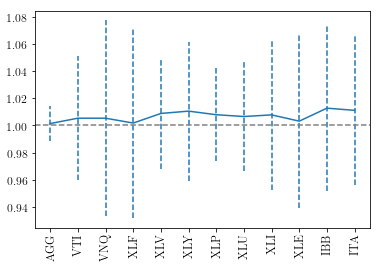

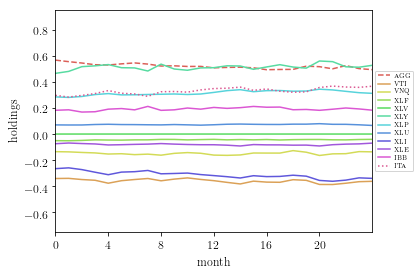

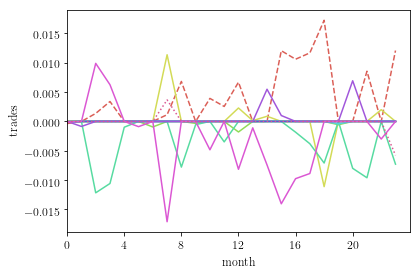

epoch 41: train utility (0.0034112820530868638) test utility (0.0047564568697332195)
epoch 42: train utility (0.00387803924726801) test utility (0.004786686517149979)
epoch 43: train utility (0.003722734739318237) test utility (0.004854464809992947)
epoch 44: train utility (0.003545495182620854) test utility (0.004874057836516236)
epoch 45: train utility (0.0062563781925877625) test utility (0.00487078218964619)
epoch 46: train utility (0.003647184705446759) test utility (0.004927721563770652)
epoch 47: train utility (0.0034468240937483062) test utility (0.004916248047961135)
epoch 48: train utility (0.004322688721282197) test utility (0.004922447327697766)
epoch 49: train utility (0.003812056644250198) test utility (0.004926115153915443)
epoch 50: train utility (0.00408073828195943) test utility (0.004979604383410664)
	mu.grad.norm  0.27316168300006205
	gamma.grad.norm  0.0004195638595828544
	cov_sqrt.grad.norm  0.3417759601719268
	gamma  14.999882159805935


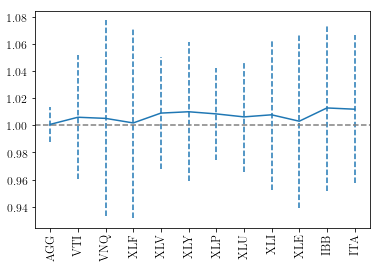

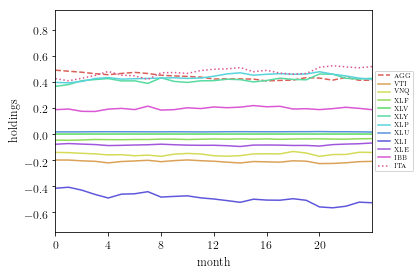

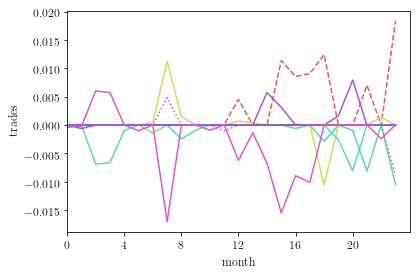

epoch 51: train utility (-0.0011209194487045362) test utility (0.004988940643771842)
epoch 52: train utility (0.0015507081028027284) test utility (0.0049236244084168036)
epoch 53: train utility (0.005004754647828526) test utility (0.004878882156887285)
epoch 54: train utility (0.0037328742209183827) test utility (0.004914122250147297)
epoch 55: train utility (0.003753706601751229) test utility (0.004912907771058761)
epoch 56: train utility (0.0042714222995717255) test utility (0.004910606295672295)
epoch 57: train utility (0.005946552928367937) test utility (0.004888406345066902)
epoch 58: train utility (0.0012639727184761442) test utility (0.004893825767505422)
epoch 59: train utility (0.0025088405020933257) test utility (0.004876995104457703)
epoch 60: train utility (0.0015745494414920957) test utility (0.004861127362930378)
	mu.grad.norm  0.32547522761470654
	gamma.grad.norm  0.0004795021651720974
	cov_sqrt.grad.norm  0.2647071732081444
	gamma  14.999877761250147


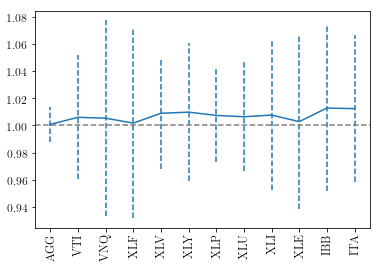

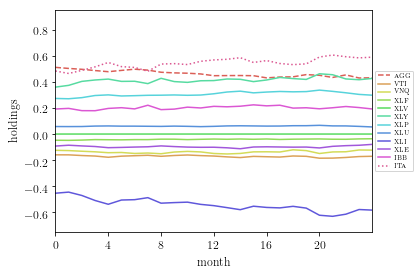

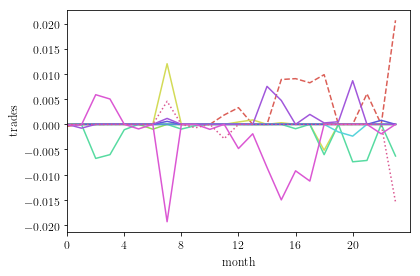

epoch 61: train utility (0.004892253689847431) test utility (0.004805045121223153)
epoch 62: train utility (0.0016927124204886468) test utility (0.004802628255597806)
epoch 63: train utility (0.0062804744766004365) test utility (0.004793423965918127)
epoch 64: train utility (0.003943768491093916) test utility (0.0048489067457840145)
epoch 65: train utility (0.003953731051046789) test utility (0.004826275627123592)
epoch 66: train utility (0.0025149528562463325) test utility (0.004839181493855205)
epoch 67: train utility (0.0017081680386800337) test utility (0.00482173215624339)
epoch 68: train utility (0.003013186209187376) test utility (0.004891278420819532)
epoch 69: train utility (0.002602756816137566) test utility (0.004886550049474482)
epoch 70: train utility (0.0025213122006266663) test utility (0.004804594392996593)
	mu.grad.norm  0.2166708711933181
	gamma.grad.norm  0.0002599996106509111
	cov_sqrt.grad.norm  0.24382034923973486
	gamma  14.999883693200635


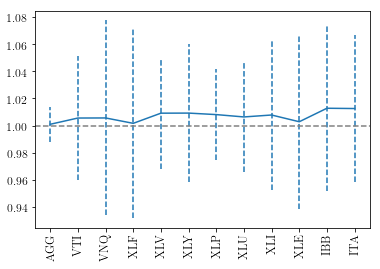

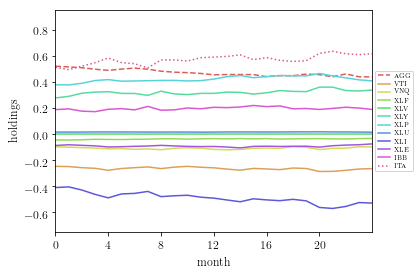

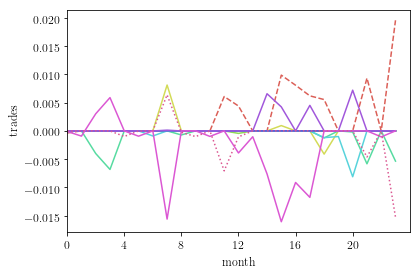

epoch 71: train utility (0.0011090978421319526) test utility (0.004737163804410418)
epoch 72: train utility (0.003032151969198298) test utility (0.00473684020983668)
epoch 73: train utility (0.005570689780341063) test utility (0.004725595472400083)
epoch 74: train utility (0.0033367013716785873) test utility (0.004746234904836419)
epoch 75: train utility (0.005310002439141273) test utility (0.004733935593948164)
epoch 76: train utility (0.005093313710772362) test utility (0.0047922604395469245)
epoch 77: train utility (0.00307122494378085) test utility (0.004757848808198618)
epoch 78: train utility (0.004983427938529156) test utility (0.004810055013650929)
epoch 79: train utility (0.005748302254659888) test utility (0.0047214175328410745)
epoch 80: train utility (0.0034172063960089933) test utility (0.004685451837652084)
	mu.grad.norm  0.5444366795400164
	gamma.grad.norm  0.000563418986682081
	cov_sqrt.grad.norm  0.5795622460335718
	gamma  14.99984502572921


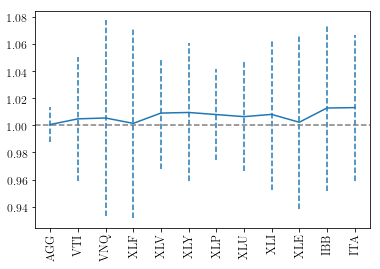

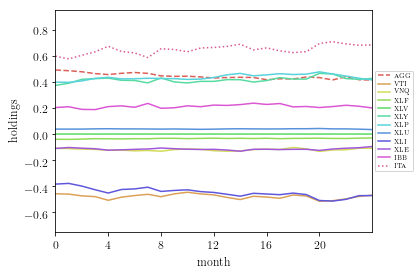

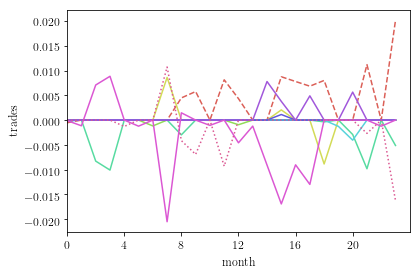

epoch 81: train utility (0.004946284913159164) test utility (0.004850052683007708)
epoch 82: train utility (0.004856217098562371) test utility (0.004968349216660162)
epoch 83: train utility (0.003344309998439084) test utility (0.005037170800368036)
epoch 84: train utility (0.0040807924018421106) test utility (0.005009610821082157)
epoch 85: train utility (0.0068839699909035825) test utility (0.005066392230694408)
epoch 86: train utility (0.005758390420476921) test utility (0.005054204931907414)
epoch 87: train utility (0.0028842328604391934) test utility (0.00511816988151046)
epoch 88: train utility (0.004020997225633352) test utility (0.005041245184207665)
epoch 89: train utility (0.0019270980338765334) test utility (0.00507448443506982)
epoch 90: train utility (0.00330061451842784) test utility (0.00503208578310494)
	mu.grad.norm  0.5503395380993925
	gamma.grad.norm  0.0009931927718019342
	cov_sqrt.grad.norm  0.5354725896319111
	gamma  14.999820445249803


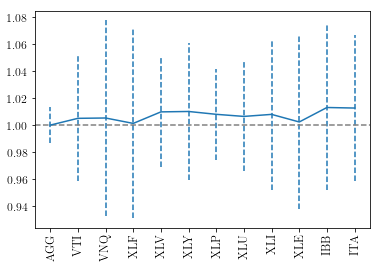

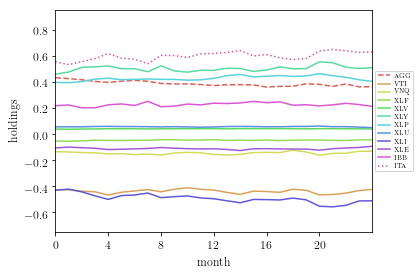

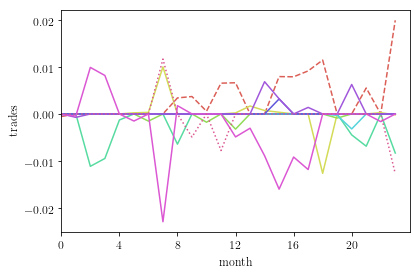

epoch 91: train utility (0.006487966861068733) test utility (0.005027527054013442)
epoch 92: train utility (0.005252973984524806) test utility (0.0050404656954821025)
epoch 93: train utility (0.004375172339144268) test utility (0.005094445120618362)
epoch 94: train utility (0.0039005191186676134) test utility (0.005082160273878415)
epoch 95: train utility (0.0038586163824954603) test utility (0.005072237294643457)
epoch 96: train utility (0.0017962905425251245) test utility (0.00510482337267914)
epoch 97: train utility (0.003129952783183269) test utility (0.00502528910510364)
epoch 98: train utility (0.004159586810794836) test utility (0.005022752846033042)
epoch 99: train utility (-1.083840498292605e-05) test utility (0.0050229830192237)
epoch 100: train utility (0.0062404776210311505) test utility (0.005014627780549259)
	mu.grad.norm  0.2876647567142076
	gamma.grad.norm  0.0008847571133922269
	cov_sqrt.grad.norm  0.368093838879946
	gamma  14.999822261666932


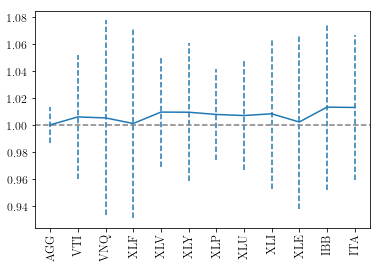

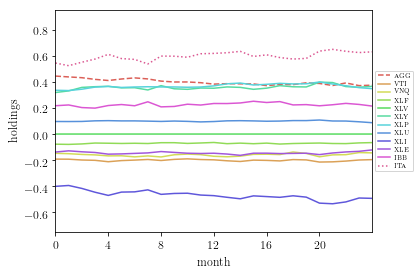

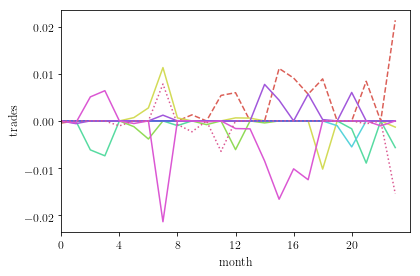

epoch 101: train utility (0.003510331865532476) test utility (0.00502402527311537)
epoch 102: train utility (0.0017409505329640724) test utility (0.005026344547284237)
epoch 103: train utility (0.006115738274526989) test utility (0.0050444568872184395)
epoch 104: train utility (0.006268704457006639) test utility (0.005066662587788662)
epoch 105: train utility (0.0008365524471333641) test utility (0.005070570933527361)
epoch 106: train utility (0.002960063186220452) test utility (0.005059742645210381)
epoch 107: train utility (-0.0003597699892901069) test utility (0.0050501130816031185)
epoch 108: train utility (0.003827077338256087) test utility (0.005038638975515287)
epoch 109: train utility (0.007339705811123418) test utility (0.005055835957421191)
epoch 110: train utility (0.003077607783714153) test utility (0.005055966190654902)
	mu.grad.norm  0.27408106221245326
	gamma.grad.norm  0.00047514563567571156
	cov_sqrt.grad.norm  0.2691611660748996
	gamma  14.999815800137128


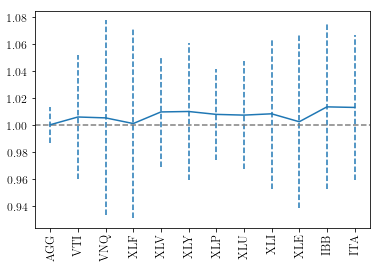

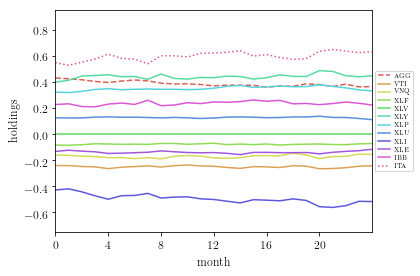

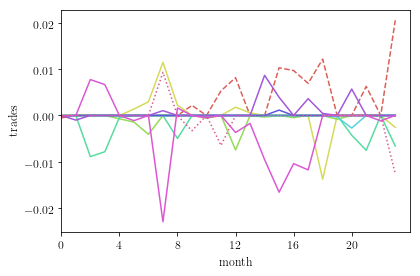

epoch 111: train utility (0.0027892096898561518) test utility (0.005074103477739865)
epoch 112: train utility (0.0006351750208576498) test utility (0.005068207106022833)
epoch 113: train utility (0.0042107243296395465) test utility (0.0050589027030463534)
epoch 114: train utility (0.0023602705525405405) test utility (0.005068289277998126)
epoch 115: train utility (0.00229767764485458) test utility (0.005050523655984155)
epoch 116: train utility (0.004842051694844212) test utility (0.005039494574761534)
epoch 117: train utility (0.005177185550835664) test utility (0.005038572158269839)
epoch 118: train utility (0.0029629274460227784) test utility (0.00505752811502368)
epoch 119: train utility (0.006877411068557544) test utility (0.005070352082954281)
epoch 120: train utility (0.0020371160694382107) test utility (0.005108765334895578)
	mu.grad.norm  0.4439725550236502
	gamma.grad.norm  0.0002763451326535577
	cov_sqrt.grad.norm  0.3770185614631735
	gamma  14.999814763269693


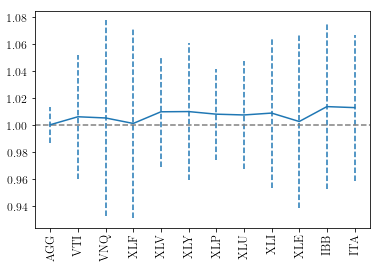

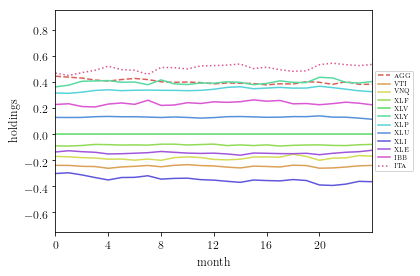

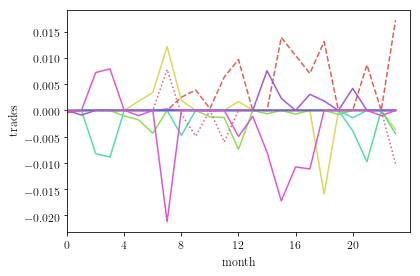

epoch 121: train utility (0.00620550898251411) test utility (0.005117857055939507)
epoch 122: train utility (0.005047349198208966) test utility (0.005121185509071007)
epoch 123: train utility (0.0003757467925676153) test utility (0.005143021556808557)
epoch 124: train utility (0.004832225981950189) test utility (0.005156837016223751)
epoch 125: train utility (0.004335199380682048) test utility (0.0051577815373426966)
epoch 126: train utility (0.005849117038930928) test utility (0.005151340709505198)
epoch 127: train utility (0.003959231536929128) test utility (0.005175086321931923)
epoch 128: train utility (0.0064827755672752395) test utility (0.005172447875621568)
epoch 129: train utility (0.006692574909011237) test utility (0.005183676630951069)
epoch 130: train utility (0.004125860459237153) test utility (0.0051854622009896035)
	mu.grad.norm  0.3851393752242116
	gamma.grad.norm  0.00012814717600734144
	cov_sqrt.grad.norm  0.3394463319941871
	gamma  14.999799155606377


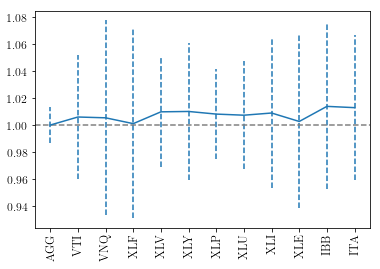

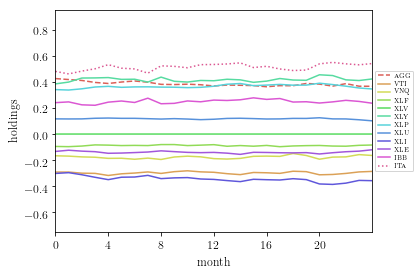

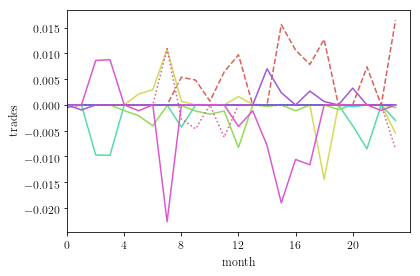

epoch 131: train utility (0.006207791463427174) test utility (0.005188036894123714)
epoch 132: train utility (0.0001780964779470067) test utility (0.0052036037238698245)
epoch 133: train utility (0.004703373519121825) test utility (0.005236471637655877)
epoch 134: train utility (0.004083849616705253) test utility (0.0052222952706320585)
epoch 135: train utility (0.004247187255599089) test utility (0.005223215451780694)
epoch 136: train utility (0.0017919494530845397) test utility (0.005214076175168116)
epoch 137: train utility (0.002457439974209638) test utility (0.005206775739057727)
epoch 138: train utility (0.006500213968869284) test utility (0.005200512476171451)
epoch 139: train utility (0.004546317265582082) test utility (0.005220603045054799)
epoch 140: train utility (0.003537453207400218) test utility (0.005234396832887662)
	mu.grad.norm  0.34011467533444706
	gamma.grad.norm  1.846511449664519e-05
	cov_sqrt.grad.norm  0.3762490422575426
	gamma  14.999800956023792


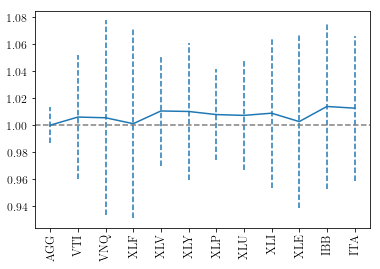

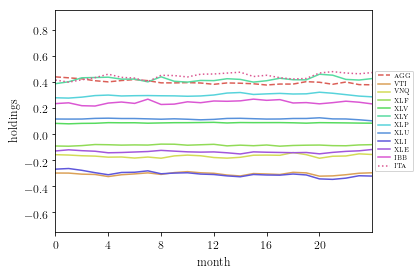

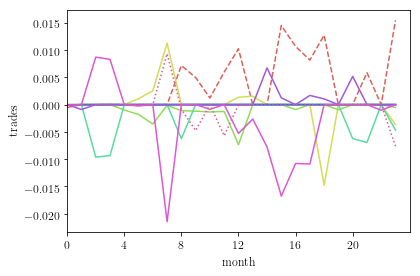

epoch 141: train utility (0.0029181451091823793) test utility (0.0052460020400780395)
epoch 142: train utility (0.001276779313843884) test utility (0.005244610131451415)
epoch 143: train utility (0.0012252615383001881) test utility (0.005233218781899864)
epoch 144: train utility (-0.0001595165897531724) test utility (0.005232151189581479)
epoch 145: train utility (0.0001668901060967193) test utility (0.00520939155781433)
epoch 146: train utility (0.0024628695416742384) test utility (0.005192640457522491)
epoch 147: train utility (0.005040529169610572) test utility (0.005200155859647765)
epoch 148: train utility (0.002590841728558819) test utility (0.005220859844209688)
epoch 149: train utility (0.0024908183296436315) test utility (0.005188176886579811)
epoch 150: train utility (-0.000411846328289912) test utility (0.005188677218663944)
	mu.grad.norm  0.295073317503858
	gamma.grad.norm  0.0010415676373727813
	cov_sqrt.grad.norm  0.26230256717199396
	gamma  14.999810814714465


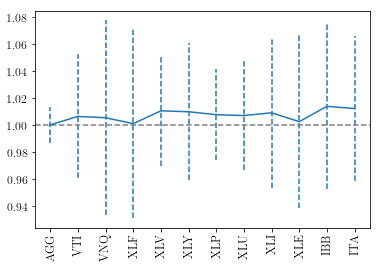

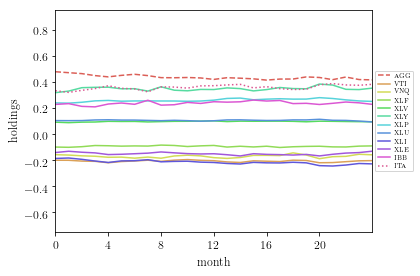

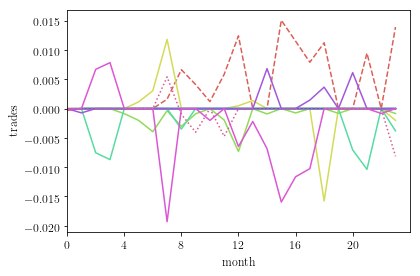

epoch 151: train utility (0.0053475752052334746) test utility (0.005170029048410005)
epoch 152: train utility (0.004368090862469488) test utility (0.005179412035452529)
epoch 153: train utility (0.00401376194524033) test utility (0.005173416171148925)
epoch 154: train utility (0.0027845185986201844) test utility (0.00518070194490111)
epoch 155: train utility (0.003271220271756669) test utility (0.005202409589707759)
epoch 156: train utility (0.005947375606941979) test utility (0.00519466401575835)
epoch 157: train utility (0.0031034474497608007) test utility (0.005190200653585683)
epoch 158: train utility (0.001374155324409886) test utility (0.005180097599374497)
epoch 159: train utility (0.004216932714657761) test utility (0.005185447486189399)
epoch 160: train utility (0.003688486798485293) test utility (0.0051886944597148215)
	mu.grad.norm  0.22045924856357144
	gamma.grad.norm  4.2563561983728615e-05
	cov_sqrt.grad.norm  0.2176819248759376
	gamma  14.99981006916808


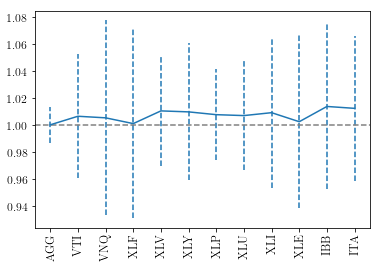

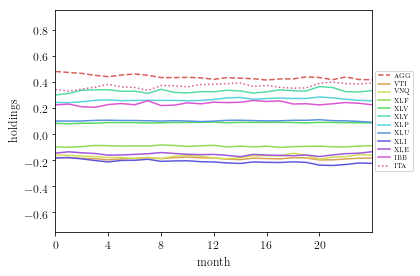

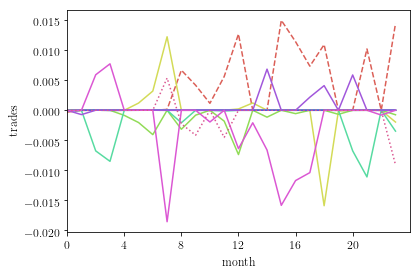

epoch 161: train utility (0.0026733034450022748) test utility (0.005181264110984115)
epoch 162: train utility (0.004600452587293935) test utility (0.005159900052701299)
epoch 163: train utility (0.003427765593528273) test utility (0.005145251872169166)
epoch 164: train utility (0.005116387668741074) test utility (0.005133472014116904)
epoch 165: train utility (0.007371092684117208) test utility (0.005129333721358142)
epoch 166: train utility (0.0028517170011959176) test utility (0.005143292158821393)
epoch 167: train utility (0.0010075395271120409) test utility (0.0051277966283397175)
epoch 168: train utility (0.0024037504825089938) test utility (0.005129084151365426)
epoch 169: train utility (0.001971258088276412) test utility (0.005117568812436648)
epoch 170: train utility (0.007358216960330925) test utility (0.005112114198801065)
	mu.grad.norm  0.26554751075302224
	gamma.grad.norm  0.0008816532651315515
	cov_sqrt.grad.norm  0.261070935363088
	gamma  14.999805942551653


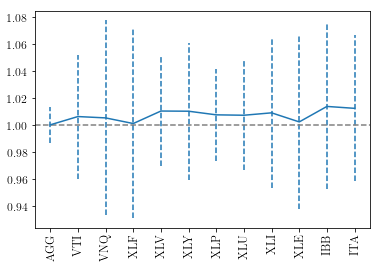

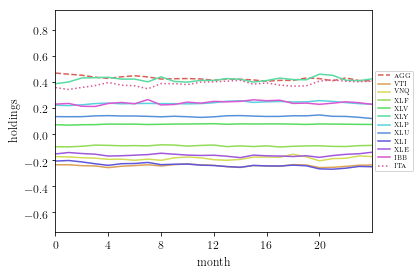

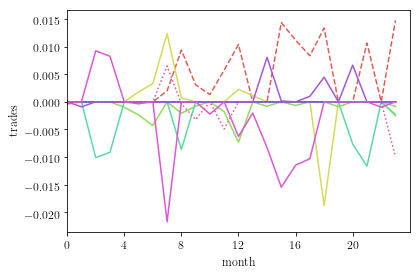

epoch 171: train utility (0.003924810083025228) test utility (0.005113524826649703)
epoch 172: train utility (0.0022607740919532516) test utility (0.00511730338694783)
epoch 173: train utility (0.004310637338843044) test utility (0.005118926098251962)
epoch 174: train utility (0.0005881070062726026) test utility (0.0051212847240344524)
epoch 175: train utility (0.0033854737289952) test utility (0.005112175290367601)
epoch 176: train utility (0.0042759104163597505) test utility (0.005114229120382447)
epoch 177: train utility (0.0054564849303138045) test utility (0.0051148595870328184)
epoch 178: train utility (0.006107872767309968) test utility (0.0051031569545356755)
epoch 179: train utility (0.007126809125300615) test utility (0.005107040695608088)
epoch 180: train utility (0.004594035196958091) test utility (0.005113850394452302)
	mu.grad.norm  0.28821193499984266
	gamma.grad.norm  0.0006426613832058361
	cov_sqrt.grad.norm  0.2440714091681851
	gamma  14.999801213840277


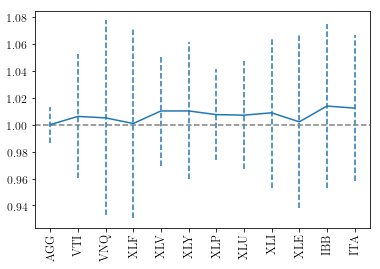

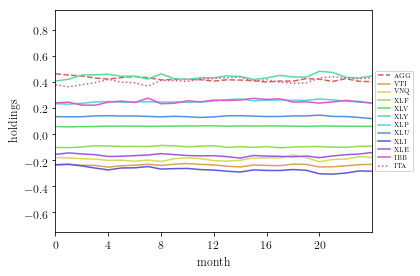

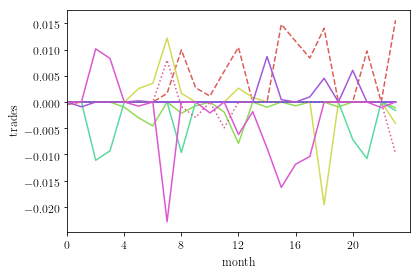

epoch 181: train utility (0.001783461262393457) test utility (0.005124390670956202)
epoch 182: train utility (0.0036822817687304993) test utility (0.005125016075125727)
epoch 183: train utility (0.00284356157209791) test utility (0.005119849842314241)
epoch 184: train utility (0.003892417841623307) test utility (0.0051369310607455275)
epoch 185: train utility (0.004691118411442306) test utility (0.0051079083752436135)
epoch 186: train utility (0.006418493461871287) test utility (0.005102804284128436)
epoch 187: train utility (0.004353739329319805) test utility (0.00511761837156493)
epoch 188: train utility (0.005288360354223228) test utility (0.005120687523804556)
epoch 189: train utility (0.004291794448320207) test utility (0.005122290031511751)
epoch 190: train utility (0.0016844980117688545) test utility (0.005129466058487692)
	mu.grad.norm  0.2769789624122361
	gamma.grad.norm  0.0008059419970767429
	cov_sqrt.grad.norm  0.3139713209613108
	gamma  14.999791469044768


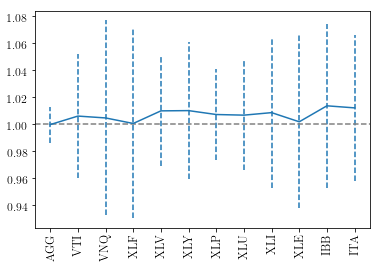

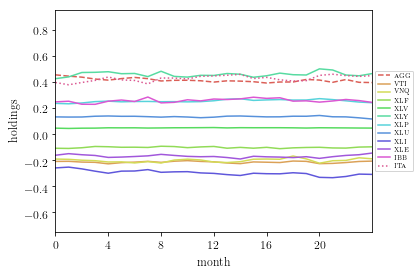

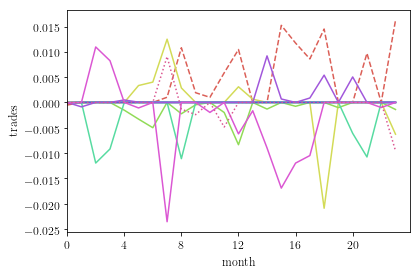

epoch 191: train utility (0.010162835779041379) test utility (0.005122019688645579)
epoch 192: train utility (0.001421832239476692) test utility (0.005156898681370983)
epoch 193: train utility (0.0065500595676414005) test utility (0.005160885402325837)
epoch 194: train utility (0.008185666106848661) test utility (0.0051489344463328144)
epoch 195: train utility (0.0026019824065978765) test utility (0.005147561551380132)
epoch 196: train utility (0.008108847508498987) test utility (0.005151021311860375)
epoch 197: train utility (0.004316231437199496) test utility (0.005160886758856539)
epoch 198: train utility (0.001371288375486777) test utility (0.00516177436019578)
epoch 199: train utility (0.004555163976044626) test utility (0.0051445668846621575)
epoch 200: train utility (0.006854805467102247) test utility (0.0051502928395416245)
	mu.grad.norm  0.28032905546566406
	gamma.grad.norm  0.0004114399961093284
	cov_sqrt.grad.norm  0.31714615584325195
	gamma  14.999775974282162


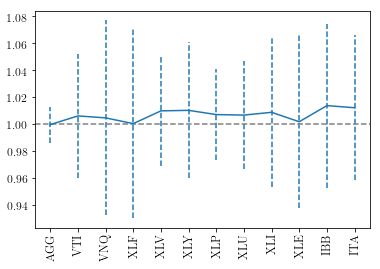

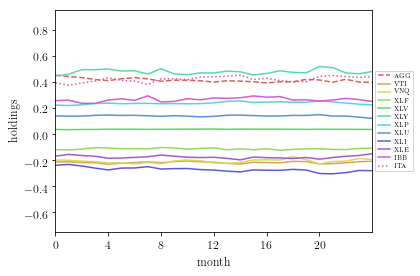

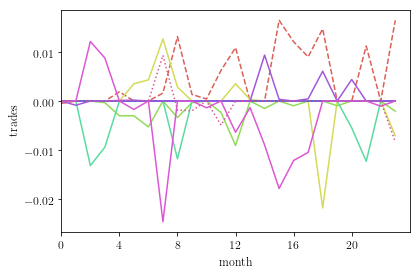

epoch 201: train utility (0.003353397536970068) test utility (0.00515743211689729)
epoch 202: train utility (0.004537613710001341) test utility (0.005162142688501558)
epoch 203: train utility (0.0021441021174619934) test utility (0.005153373000004402)
epoch 204: train utility (0.006783876227867714) test utility (0.005150994141888562)
epoch 205: train utility (0.0027675497468999076) test utility (0.005159386875987009)
epoch 206: train utility (0.002595915963735893) test utility (0.005173830001524132)
epoch 207: train utility (0.004346619653139689) test utility (0.005172606563950898)
epoch 208: train utility (0.0008871751782416478) test utility (0.005174925947530223)
epoch 209: train utility (0.004732884571166099) test utility (0.00517604550484579)
epoch 210: train utility (0.002857832611051599) test utility (0.005175809149723912)
	mu.grad.norm  0.37020481957859636
	gamma.grad.norm  0.000259864981264644
	cov_sqrt.grad.norm  0.3203454622717959
	gamma  14.999772218671493


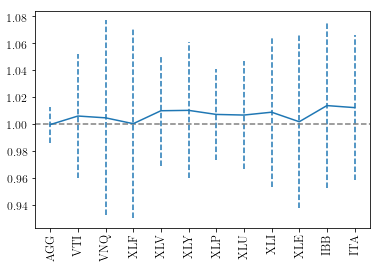

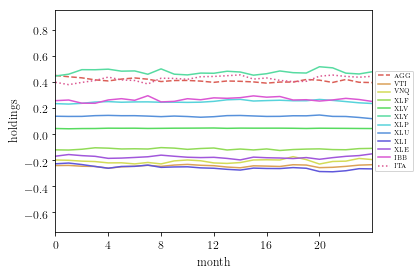

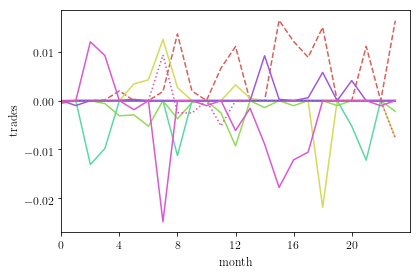

epoch 211: train utility (0.0032448261766858015) test utility (0.0051676688588418365)
epoch 212: train utility (0.0029467575718679856) test utility (0.0051713310806396975)
epoch 213: train utility (0.0026293469912233363) test utility (0.005162452385676599)
epoch 214: train utility (0.005728525648867467) test utility (0.005151762820526729)
epoch 215: train utility (0.004523777558981835) test utility (0.005155400626163072)
epoch 216: train utility (0.006516454145385975) test utility (0.005165240919210595)
epoch 217: train utility (0.0048075895924342025) test utility (0.00517043932030202)
epoch 218: train utility (0.005588695093837499) test utility (0.005160687285973919)
epoch 219: train utility (0.004434306874686337) test utility (0.0051774333340709675)
epoch 220: train utility (0.0015057433778787282) test utility (0.005191005697319765)
	mu.grad.norm  0.3219819159532613
	gamma.grad.norm  0.0006813168774893691
	cov_sqrt.grad.norm  0.2965723425759886
	gamma  14.999771680014938


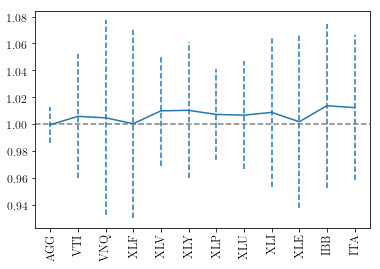

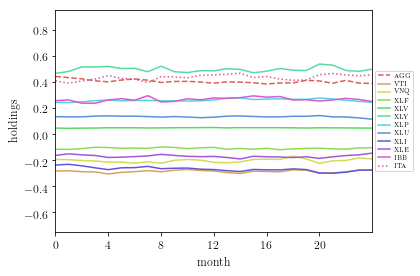

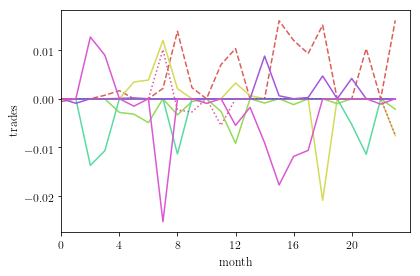

epoch 221: train utility (0.002854596676315533) test utility (0.005187237668481033)
epoch 222: train utility (0.0022769089243472387) test utility (0.005191028359182903)
epoch 223: train utility (0.002081954380886605) test utility (0.0051973837210406845)
epoch 224: train utility (0.006054940906043527) test utility (0.005200582484478194)
epoch 225: train utility (0.007400823332783105) test utility (0.005220487708273139)
epoch 226: train utility (0.003713466313528564) test utility (0.005232307289167901)
epoch 227: train utility (0.007908512989312208) test utility (0.005242366113607022)
epoch 228: train utility (0.006863387919906561) test utility (0.00525240331772591)
epoch 229: train utility (0.0034641516746749764) test utility (0.00526030512253702)
epoch 230: train utility (0.00300025196007441) test utility (0.005262904517942604)
	mu.grad.norm  0.29537639553408807
	gamma.grad.norm  0.0006352757239547019
	cov_sqrt.grad.norm  0.27090353247141125
	gamma  14.999765493602842


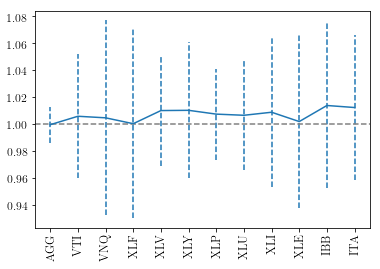

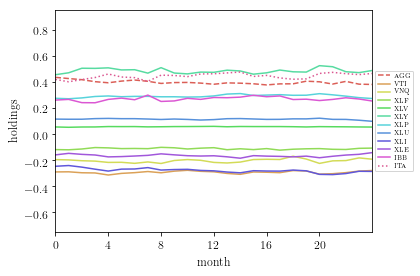

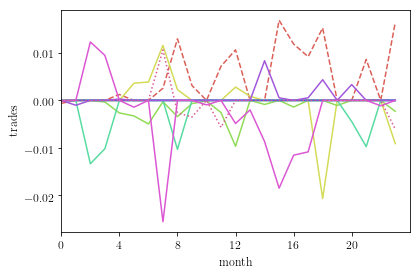

epoch 231: train utility (0.004141919470973256) test utility (0.005254039985352745)
epoch 232: train utility (0.0011576607056247858) test utility (0.00525638313684052)
epoch 233: train utility (0.0049643621211613535) test utility (0.005255512811097143)
epoch 234: train utility (0.004221408906043824) test utility (0.005259620364716848)
epoch 235: train utility (0.003450509163786257) test utility (0.0052667819916062345)
epoch 236: train utility (0.0052270874390975995) test utility (0.005267676146650321)
epoch 237: train utility (0.005830609264486264) test utility (0.005275068489063479)
epoch 238: train utility (0.004515305204970089) test utility (0.005277827484192108)
epoch 239: train utility (0.005005988480253342) test utility (0.0052703129021781665)
epoch 240: train utility (0.0004951000835835223) test utility (0.005276361776658293)
	mu.grad.norm  0.7174966100068317
	gamma.grad.norm  0.0015449164240888657
	cov_sqrt.grad.norm  0.6391796098619844
	gamma  14.999762057290388


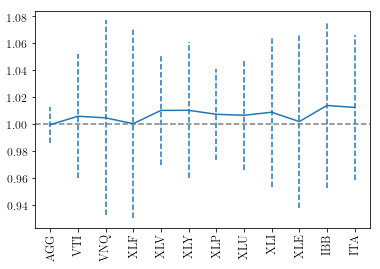

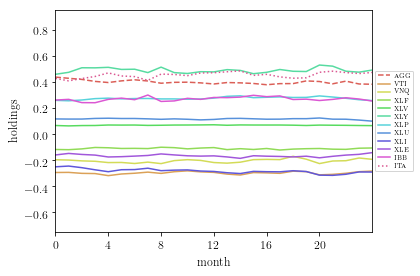

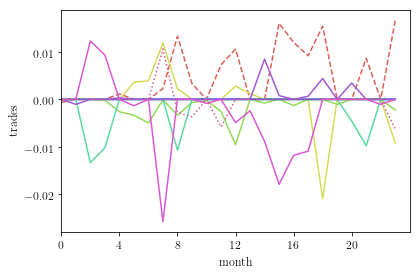

epoch 241: train utility (0.0011915692610352923) test utility (0.005283489749651273)
epoch 242: train utility (0.007743359635377783) test utility (0.005286434654609456)
epoch 243: train utility (-0.0004128317921407997) test utility (0.00529379762819235)
epoch 244: train utility (0.004642803744437866) test utility (0.0052950753767087855)
epoch 245: train utility (0.003237986769974469) test utility (0.005287089609307522)
epoch 246: train utility (0.0013802452258119267) test utility (0.00528424482794672)
epoch 247: train utility (0.006250558462306826) test utility (0.005272291797059996)
epoch 248: train utility (0.007044544818901153) test utility (0.00527759297911074)
epoch 249: train utility (0.005713370102148555) test utility (0.0052830515782591484)
epoch 250: train utility (0.003220109199438993) test utility (0.00528656173863004)
	mu.grad.norm  0.4423715198199348
	gamma.grad.norm  0.0004560173690799999
	cov_sqrt.grad.norm  0.41384191907337203
	gamma  14.999761432777682


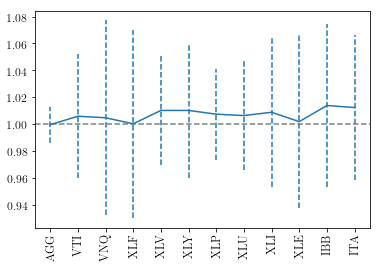

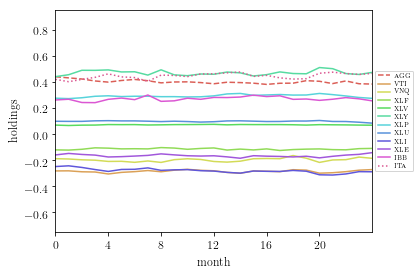

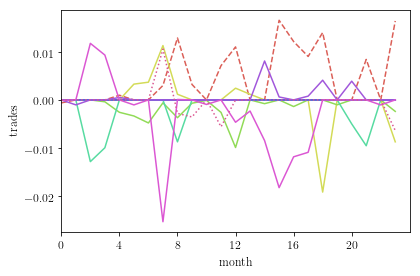

epoch 251: train utility (0.0017107895376734963) test utility (0.005302323819110799)
epoch 252: train utility (0.003059730585123665) test utility (0.005291686325223935)
epoch 253: train utility (0.0023347293222153245) test utility (0.005287280018751316)
epoch 254: train utility (0.0038465765109763498) test utility (0.005284349347851899)
epoch 255: train utility (0.002811794179443402) test utility (0.005277023040672357)
epoch 256: train utility (0.005790448272581744) test utility (0.005264086256880549)
epoch 257: train utility (0.006368299788028049) test utility (0.005274092290748098)
epoch 258: train utility (0.004428072055446761) test utility (0.0052808460874083415)
epoch 259: train utility (0.004133403635766088) test utility (0.005289900793490408)
epoch 260: train utility (0.0017187438437601308) test utility (0.005297792355452281)
	mu.grad.norm  0.35714776762956824
	gamma.grad.norm  0.0013621829451996015
	cov_sqrt.grad.norm  0.39690272156965845
	gamma  14.999757780728427


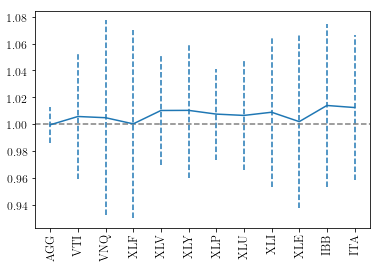

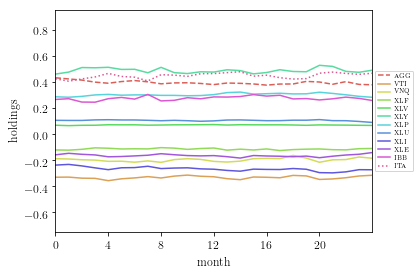

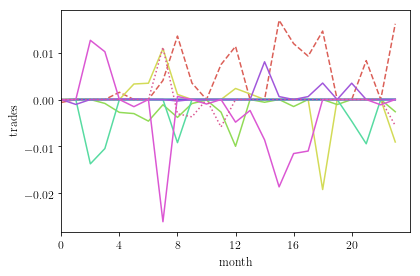

epoch 261: train utility (0.0021335830962742504) test utility (0.00529681471598381)
epoch 262: train utility (0.004754045235944566) test utility (0.005292317381159492)
epoch 263: train utility (0.005862713145752826) test utility (0.005289785985637391)
epoch 264: train utility (0.00316107158342335) test utility (0.005302293402672128)
epoch 265: train utility (0.002964035068821372) test utility (0.005308171592270027)
epoch 266: train utility (0.003871010728151768) test utility (0.0053068535114082546)
epoch 267: train utility (-0.0014256765953300575) test utility (0.005313732558727176)
epoch 268: train utility (0.003189830773981519) test utility (0.0053056281707264796)
epoch 269: train utility (0.003894472670512063) test utility (0.005312225088835479)
epoch 270: train utility (0.0056473807400621474) test utility (0.0053199729797292735)
	mu.grad.norm  0.38426993678631793
	gamma.grad.norm  0.001161704881681895
	cov_sqrt.grad.norm  0.4013047227859893
	gamma  14.999761526962635


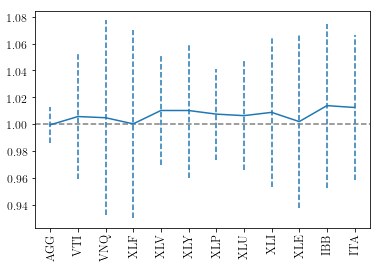

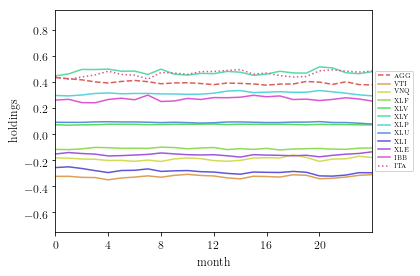

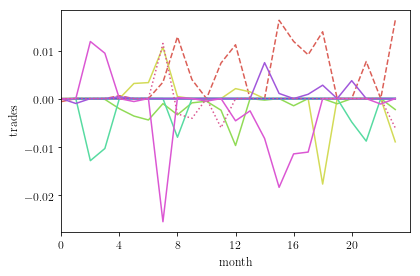

epoch 271: train utility (0.006301862456129749) test utility (0.0053256689245578075)
epoch 272: train utility (0.008265289126266787) test utility (0.005334585563727146)
epoch 273: train utility (0.0011829104412417256) test utility (0.005347900665840876)
epoch 274: train utility (0.0033878439016854648) test utility (0.0053514267898045285)
epoch 275: train utility (0.004748110437026014) test utility (0.005354981798863146)
epoch 276: train utility (0.0016353145159696103) test utility (0.005356518645589245)
epoch 277: train utility (0.0040393425781981105) test utility (0.005347676220376613)
epoch 278: train utility (0.0030597628252876244) test utility (0.005353726848393618)
epoch 279: train utility (0.005026210720963186) test utility (0.005348063163783936)
epoch 280: train utility (0.006341598795893905) test utility (0.005351151187955522)
	mu.grad.norm  0.32691245779383626
	gamma.grad.norm  0.001125978653812861
	cov_sqrt.grad.norm  0.3696633772422758
	gamma  14.999757628463552


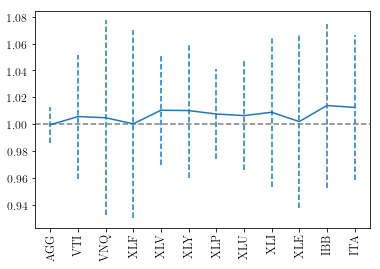

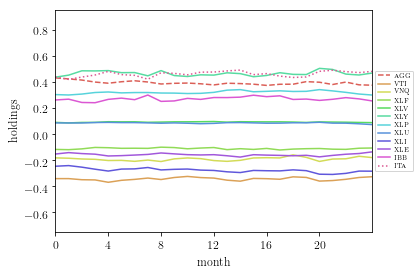

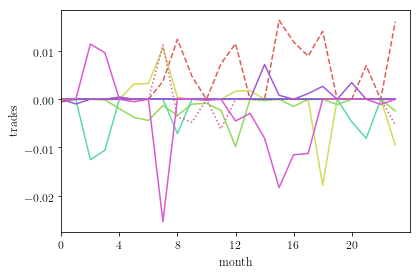

epoch 281: train utility (0.0031363133476252567) test utility (0.005350167992097346)
epoch 282: train utility (0.0010817777332365313) test utility (0.005346876104681386)
epoch 283: train utility (0.005035749515365002) test utility (0.005342359966870971)
epoch 284: train utility (0.004330690198713006) test utility (0.005339938372211816)
epoch 285: train utility (0.003968568904882147) test utility (0.005343940781505768)
epoch 286: train utility (0.0014982356625606373) test utility (0.005338006614176103)
epoch 287: train utility (0.004753105210428445) test utility (0.005325768323206999)
epoch 288: train utility (0.005845486407104024) test utility (0.005322309400378552)
epoch 289: train utility (0.0039372426163786) test utility (0.0053170681174045204)
epoch 290: train utility (0.003373950196177579) test utility (0.005326813162049363)
	mu.grad.norm  0.3506069069411168
	gamma.grad.norm  0.00013491271008844562
	cov_sqrt.grad.norm  0.387483872031453
	gamma  14.999757615788864


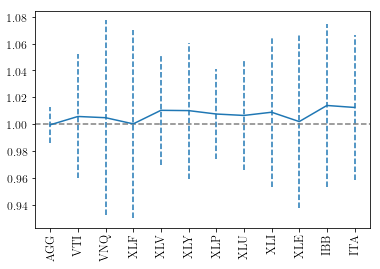

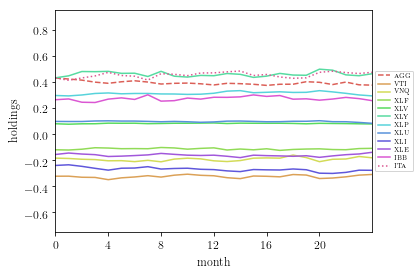

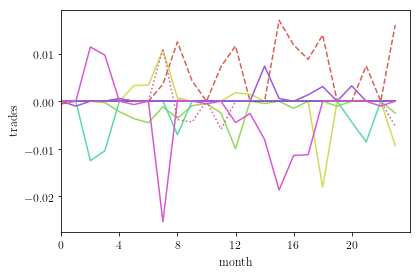

epoch 291: train utility (0.007070960109462697) test utility (0.005326055432170487)
epoch 292: train utility (0.001581116693176035) test utility (0.005329256470242861)
epoch 293: train utility (0.0032844182855144752) test utility (0.005320337267758116)
epoch 294: train utility (0.004859131525565065) test utility (0.005325535771711989)
epoch 295: train utility (0.00518242918407028) test utility (0.005331420593718654)
epoch 296: train utility (0.004896774549323335) test utility (0.005330853593055952)
epoch 297: train utility (0.0030547757308811334) test utility (0.00532042940392795)
epoch 298: train utility (0.0006890604655914927) test utility (0.005318876717944391)
epoch 299: train utility (0.0035047275319033803) test utility (0.005319611046343019)
epoch 300: train utility (0.005486922727264118) test utility (0.005317434582622084)
	mu.grad.norm  0.5098619081077402
	gamma.grad.norm  0.0001618184003340103
	cov_sqrt.grad.norm  0.3864875155789226
	gamma  14.999756655625209


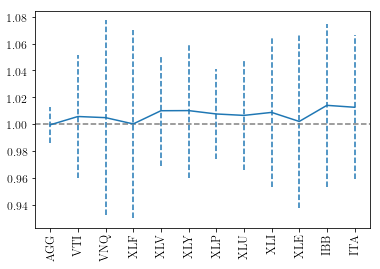

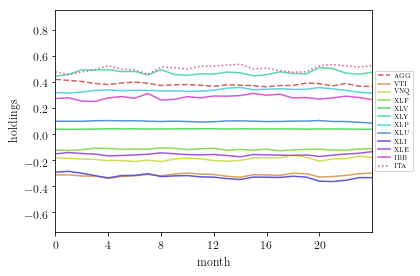

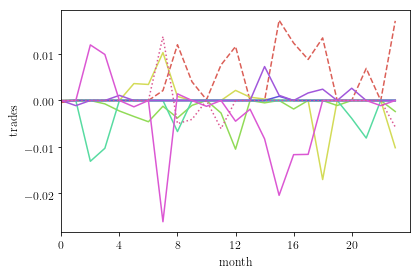

epoch 301: train utility (0.005781330299130082) test utility (0.0053108059750086815)
epoch 302: train utility (0.0010258704036846793) test utility (0.00530911073090652)
epoch 303: train utility (0.0017354728131146878) test utility (0.005307384320649563)
epoch 304: train utility (0.0048777380684440685) test utility (0.005310324030594672)
epoch 305: train utility (0.0013151428323975784) test utility (0.005315067359290994)
epoch 306: train utility (0.008140386232649276) test utility (0.005314783276898804)
epoch 307: train utility (0.004013475822362646) test utility (0.0053155071609129745)
epoch 308: train utility (0.0024028517214547) test utility (0.0053145025433506046)
epoch 309: train utility (0.0047727180763746085) test utility (0.005317203012753615)
epoch 310: train utility (0.004446160832825129) test utility (0.005321141850919825)
	mu.grad.norm  0.48732320567459697
	gamma.grad.norm  0.00043191763325267873
	cov_sqrt.grad.norm  0.3922561340862248
	gamma  14.999754971320423


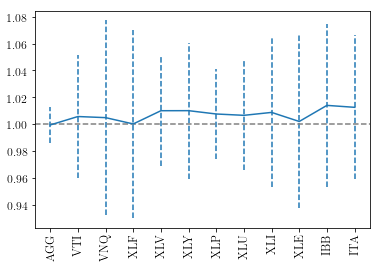

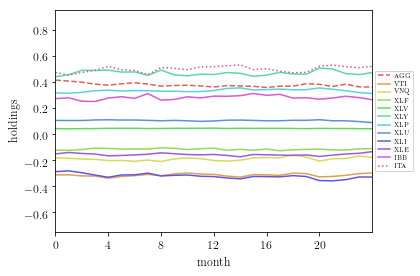

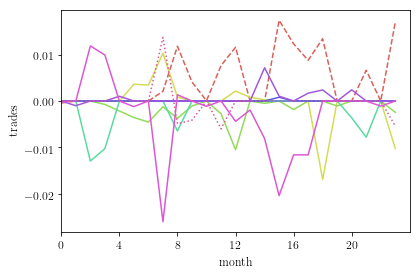

epoch 311: train utility (0.003820412642160185) test utility (0.005325575256936065)
epoch 312: train utility (0.004637392819493904) test utility (0.005325329264027489)
epoch 313: train utility (0.004736108037854878) test utility (0.005329994306729017)
epoch 314: train utility (0.0011245605568779133) test utility (0.0053232811663528)
epoch 315: train utility (0.004763847179641117) test utility (0.005321760226837563)
epoch 316: train utility (0.0023401349706532763) test utility (0.005323392585510395)
epoch 317: train utility (0.004500844893498062) test utility (0.005322812097421728)
epoch 318: train utility (0.006864225593936134) test utility (0.005323254568897743)
epoch 319: train utility (0.002871899648402876) test utility (0.005325263905785928)
epoch 320: train utility (0.007064079955116091) test utility (0.0053272971080849645)
	mu.grad.norm  0.4415486054567974
	gamma.grad.norm  0.001351577589436647
	cov_sqrt.grad.norm  0.46384757882639244
	gamma  14.999754031852143


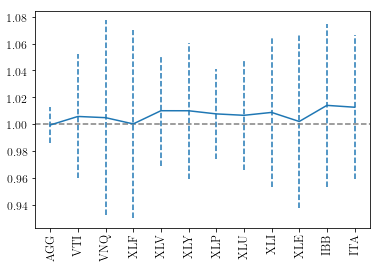

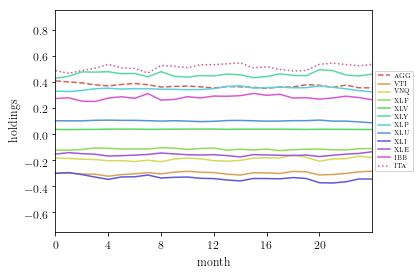

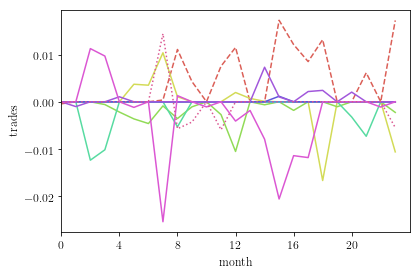

epoch 321: train utility (0.006216623510395) test utility (0.005328284291364792)
epoch 322: train utility (0.003242099383102266) test utility (0.005327960758821544)
epoch 323: train utility (0.00464772190409777) test utility (0.00533050689323464)
epoch 324: train utility (0.0028869134101333965) test utility (0.005327076774600409)
epoch 325: train utility (0.0049558480578341954) test utility (0.0053287758169669516)
epoch 326: train utility (0.0024576700411246643) test utility (0.0053262358027624645)
epoch 327: train utility (0.004987989485524976) test utility (0.0053208444699431754)
epoch 328: train utility (0.005093617133554814) test utility (0.005323332666394448)
epoch 329: train utility (0.004385530525051903) test utility (0.00532479119507265)
epoch 330: train utility (0.003150785878981404) test utility (0.005323135132217481)
	mu.grad.norm  0.27574913686569447
	gamma.grad.norm  0.0003037286452222381
	cov_sqrt.grad.norm  0.3358252056184433
	gamma  14.999750719405784


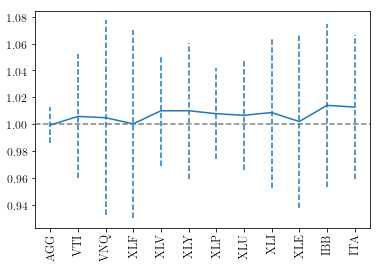

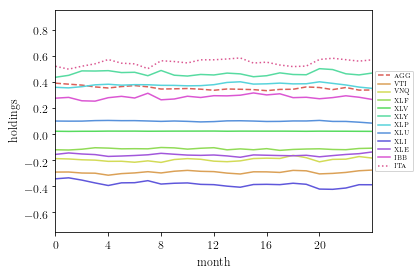

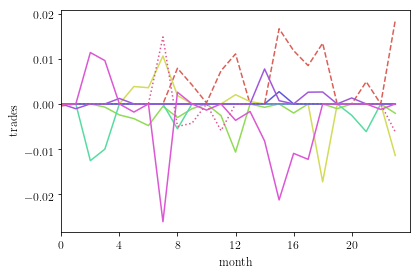

epoch 331: train utility (0.003861964320214131) test utility (0.005320567183998505)
epoch 332: train utility (0.002769866292195556) test utility (0.00531961817837616)
epoch 333: train utility (0.0006342886401549148) test utility (0.005320099625470083)
epoch 334: train utility (0.0016351663696979487) test utility (0.0053151991232475064)
epoch 335: train utility (0.0037042944907111942) test utility (0.005314233583195791)
epoch 336: train utility (0.005831131540976966) test utility (0.005312658910552372)
epoch 337: train utility (0.0009071968203134481) test utility (0.005315226365112526)
epoch 338: train utility (0.00397310548462328) test utility (0.00531393992240729)
epoch 339: train utility (0.006547079498254477) test utility (0.005313797391110409)
epoch 340: train utility (0.006143466774498752) test utility (0.005322741293417621)
	mu.grad.norm  0.29805961071637127
	gamma.grad.norm  0.00042524783071348695
	cov_sqrt.grad.norm  0.39140976410599493
	gamma  14.99975231017455


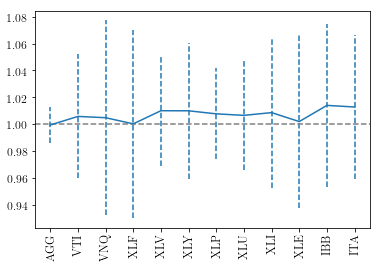

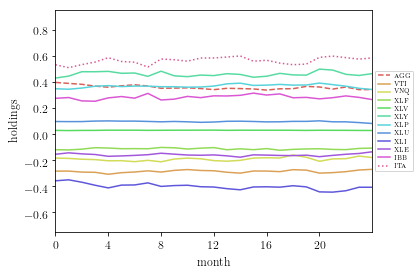

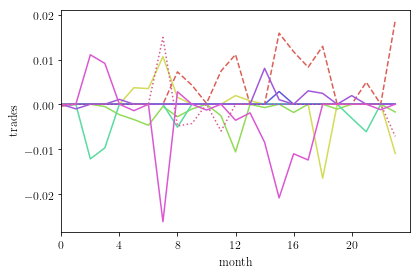

epoch 341: train utility (0.002421706177496984) test utility (0.005323634973966877)
epoch 342: train utility (0.005548533058723416) test utility (0.0053209338928310364)
epoch 343: train utility (0.003515347396169966) test utility (0.005320052802392457)
epoch 344: train utility (0.00492837305806967) test utility (0.005317585853637284)
epoch 345: train utility (0.005009993353946236) test utility (0.005314216487504681)
epoch 346: train utility (0.0035709644622469996) test utility (0.00530833050075858)
epoch 347: train utility (0.004822542646851692) test utility (0.005305627873601515)
epoch 348: train utility (0.004236315766959979) test utility (0.00530906911351957)
epoch 349: train utility (0.0006194020075059581) test utility (0.005311935791874102)
epoch 350: train utility (0.0008146779965395817) test utility (0.0053105362549831815)
	mu.grad.norm  0.36343725429827917
	gamma.grad.norm  0.0007047772628127307
	cov_sqrt.grad.norm  0.37597290690691393
	gamma  14.99975140594029


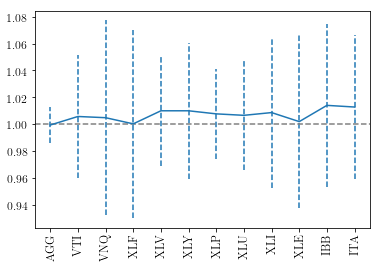

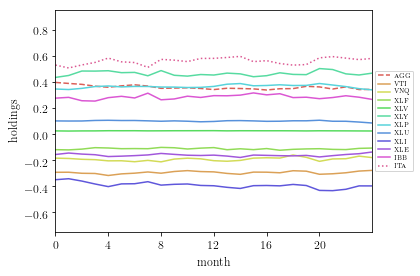

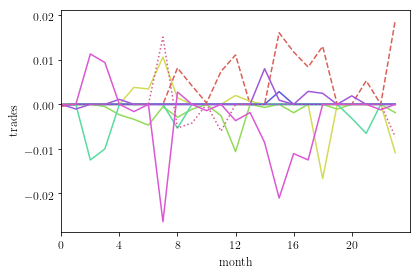

epoch 351: train utility (0.007184689397980432) test utility (0.005307386468591984)
epoch 352: train utility (0.006181255724936776) test utility (0.005301601491280318)
epoch 353: train utility (0.001059759959240574) test utility (0.005302172340963052)
epoch 354: train utility (0.005799608530416695) test utility (0.005305155065194934)
epoch 355: train utility (0.0034844127166057323) test utility (0.005302537385458253)
epoch 356: train utility (0.0030514087985427122) test utility (0.005296094238465304)
epoch 357: train utility (0.006135481943416939) test utility (0.00529425913867734)
epoch 358: train utility (0.002688482927346838) test utility (0.0052983755291460075)
epoch 359: train utility (0.005638278510199866) test utility (0.005294459100538723)
epoch 360: train utility (0.0038008280768338314) test utility (0.005301284357211242)
	mu.grad.norm  0.1782862552141747
	gamma.grad.norm  0.0008959345098683235
	cov_sqrt.grad.norm  0.23102952353276357
	gamma  14.999750311265084


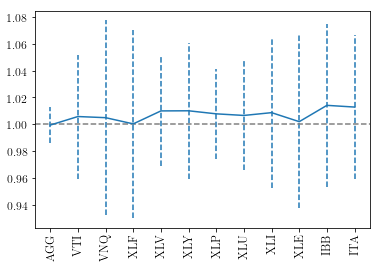

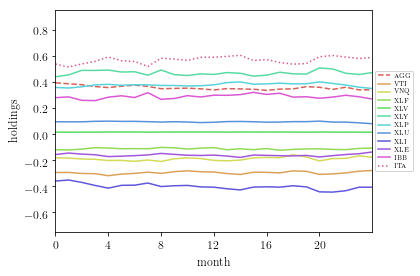

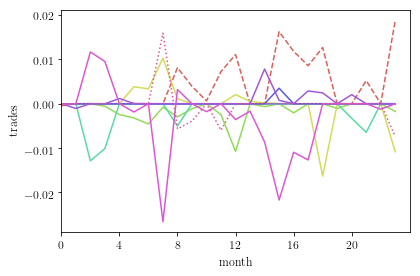

epoch 361: train utility (-0.002575590855769962) test utility (0.005301619273726827)
epoch 362: train utility (0.005133028023373168) test utility (0.0053034646919932395)
epoch 363: train utility (0.003918273349343986) test utility (0.005304428486184966)
epoch 364: train utility (0.006715164228554743) test utility (0.005311714131317111)
epoch 365: train utility (0.004126993623431099) test utility (0.005316045997813666)
epoch 366: train utility (0.004303867204486512) test utility (0.00531642699322682)
epoch 367: train utility (0.004335586260943868) test utility (0.005311235325956694)
epoch 368: train utility (0.0001965982584253784) test utility (0.005316051442584245)
epoch 369: train utility (0.005941402363060305) test utility (0.005316339083054279)
epoch 370: train utility (0.005087697752194019) test utility (0.005315266218265118)
	mu.grad.norm  0.4531045149265879
	gamma.grad.norm  0.0005803701952709162
	cov_sqrt.grad.norm  0.3912377152809778
	gamma  14.999749862729256


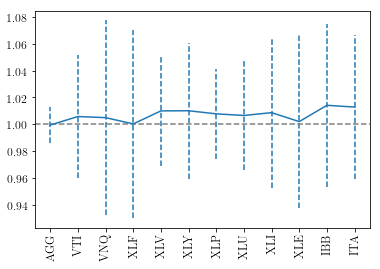

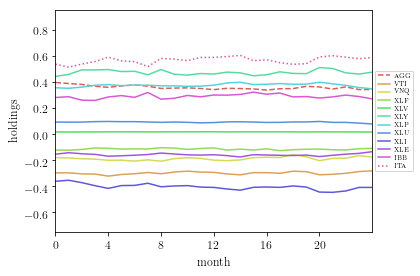

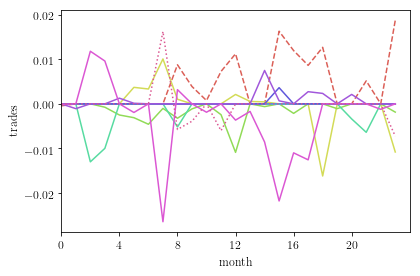

epoch 371: train utility (0.004547941020856677) test utility (0.00532173674705416)
epoch 372: train utility (0.0034935574568585696) test utility (0.005326220753895388)
epoch 373: train utility (0.0016621924770137692) test utility (0.0053230682168195044)
epoch 374: train utility (0.002213701017244061) test utility (0.005316256902588395)
epoch 375: train utility (0.00552482302446459) test utility (0.0053176796703294105)
epoch 376: train utility (0.00818853928844811) test utility (0.005316903656768478)
epoch 377: train utility (0.005694504663550351) test utility (0.005319139772726683)
epoch 378: train utility (0.004708839295744663) test utility (0.0053191154887054625)
epoch 379: train utility (0.0062046576881672815) test utility (0.005321238837032808)
epoch 380: train utility (0.00404133758329404) test utility (0.005323487728883428)
	mu.grad.norm  0.3250330392052255
	gamma.grad.norm  0.0003953592397904212
	cov_sqrt.grad.norm  0.36416156041617775
	gamma  14.999747302676695


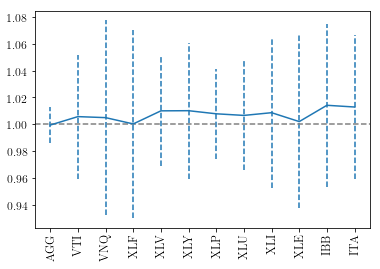

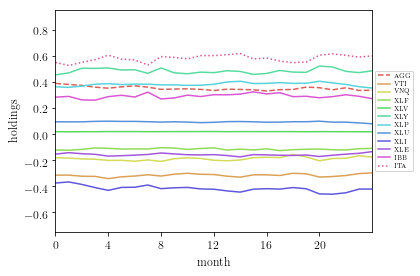

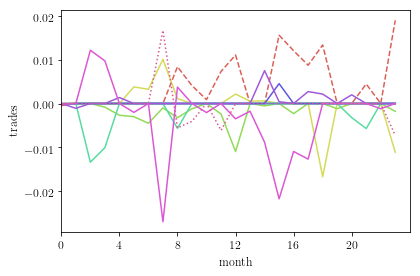

epoch 381: train utility (0.005595505764952073) test utility (0.005325555710901758)
epoch 382: train utility (-0.000872904781642583) test utility (0.005322240538078401)
epoch 383: train utility (0.005699673531922315) test utility (0.00531996785304984)
epoch 384: train utility (0.00322567268458178) test utility (0.005325487307619314)
epoch 385: train utility (0.00016653716431446944) test utility (0.005327387766603431)
epoch 386: train utility (0.003347337293289389) test utility (0.0053321465497154896)
epoch 387: train utility (0.004735535318589586) test utility (0.005325091026714402)
epoch 388: train utility (-4.583946293858121e-05) test utility (0.005323963142088414)
epoch 389: train utility (0.005882246637581214) test utility (0.005320218796009404)
epoch 390: train utility (0.005658600293002672) test utility (0.0053226444620944335)
	mu.grad.norm  0.3171113181220712
	gamma.grad.norm  0.0006381741213409394
	cov_sqrt.grad.norm  0.3574374571471956
	gamma  14.99974897897184


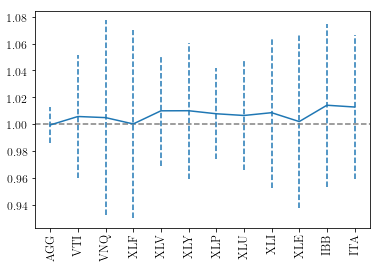

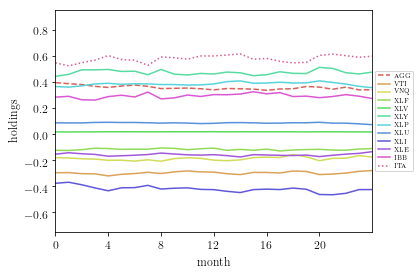

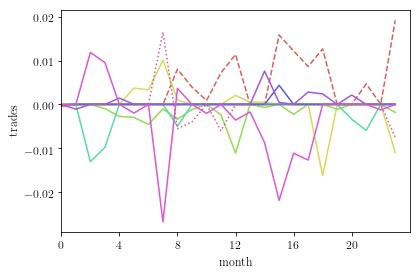

epoch 391: train utility (0.0021582564340963282) test utility (0.005327785729371716)
epoch 392: train utility (0.00383248862213535) test utility (0.005338262582195786)
epoch 393: train utility (0.004811333442281308) test utility (0.005340685751444706)
epoch 394: train utility (0.003970361712292697) test utility (0.005344297878409957)
epoch 395: train utility (0.003909756222470293) test utility (0.005349816035639793)
epoch 396: train utility (0.0033279616763083504) test utility (0.005340619856000785)
epoch 397: train utility (0.003193145007034704) test utility (0.005341377725995621)
epoch 398: train utility (0.0024463857877629258) test utility (0.005341163514252777)
epoch 399: train utility (0.0017385422724339801) test utility (0.005339202716434067)



In [17]:
TOTAL_SIMS = 4000
BATCH_SIZE = 10
EPOCHS = int(TOTAL_SIMS / BATCH_SIZE)
LR = 1e-3
PRINT_EVERY = 100 / BATCH_SIZE
MU_INIT = MU
GAMMA_INIT = GAMMA
COV_INIT = COV_SQRT
tuned = Tuner(mu=MU_INIT, gamma=GAMMA_INIT, cov_sqrt=COV_INIT)
test_utils = train(tuned, lr=LR, epochs=EPOCHS, batch_size=BATCH_SIZE, print_every=PRINT_EVERY)

In [18]:
tuned_h0 = init_holdings(tuned.cov_sqrt.detach().numpy(),
                         tuned.mu.detach().numpy(),
                         tuned.gamma_sqrt.detach().item()**2)
tuned_h0 = torch.tensor(tuned_h0)

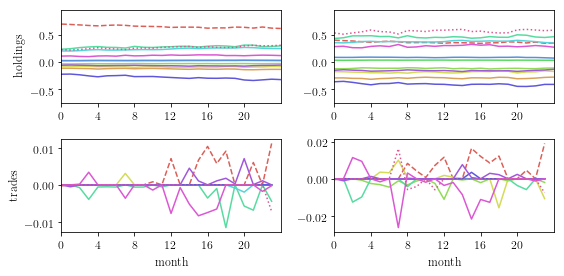

In [19]:
latexify(fig_width=8.0, fig_height=4.0)
fig, axs = plt.subplots(2, 2)

plot_states(untuned, ax=axs[0][0], h0=H0, seed=TEST, xlabel=False, legend=False, style=STYLE)
plot_states(tuned, ax=axs[0][1], h0=tuned_h0, seed=TEST, ylabel=False, xlabel=False, legend=False, style=STYLE)


plot_controls(untuned, ax=axs[1][0], h0=H0, seed=TEST, style=STYLE)
plot_controls(tuned, ax=axs[1][1], h0=tuned_h0, seed=TEST, ylabel=False,style=STYLE)

plt.savefig('mark-state-ctrl.pdf')

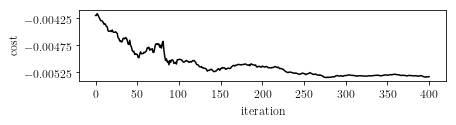

In [20]:
latexify(fig_width=6.5, fig_height=1.9)

_, ax = plt.subplots(1, 1)
ax.plot([-u for u in test_utils], color='black')
ax.set_ylabel('cost')
ax.set_xlabel('iteration')
ax.set_yticks([-0.00425, -0.00475, -0.00525])
plt.tight_layout()
plt.savefig('mark-training.pdf')

In [21]:
print(ETFS)


print(tuned.mu.detach().numpy())

['AGG', 'VTI', 'VNQ', 'XLF', 'XLV', 'XLY', 'XLP', 'XLU', 'XLI', 'XLE', 'IBB', 'ITA']
[0.9994791  1.00578426 1.00495479 1.00023491 1.01009663 1.01000145
 1.00776987 1.00651492 1.00862006 1.00200405 1.01417435 1.01277716]


In [22]:
print(MU)

[1.0031148  1.00611917 1.00599229 1.00230292 1.00891332 1.00917445
 1.00744866 1.00641088 1.00748575 1.00363468 1.01114635 1.01067012]


In [23]:
tuned.gamma_sqrt.item()**2

14.999748992882903

In [24]:
est_cov = (tuned.cov_sqrt.T @ tuned.cov_sqrt).detach().numpy()
np.median(np.abs((COV - est_cov) / COV))

0.029691643269751593

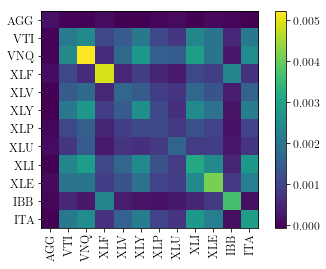

In [25]:
latexify(fig_width=6, fig_height=4)

plt.imshow(est_cov)
plt.colorbar()
plt.xticks(np.arange(N_ASSETS), ETFS, rotation=90)
plt.yticks(np.arange(N_ASSETS), ETFS)
plt.show()